In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth
import timeit
from scipy import optimize
import tables
import h5py

#!jt -t onedork -cellw 90%

/home/brandon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
uscal=100
vscal=10
extraterms=True

In [3]:
rnputil=np.load('rnputil.npy')
urange=np.load('urange.npy')[::uscal]
vrange=np.load('vrange.npy')[::vscal]

In [4]:
with h5py.File('rnp.h5','r') as f:
    r_group_key = list(f.keys())[0]
    rnpi=f[r_group_key]
    rnp = np.asarray(rnpi[::uscal,::vscal],dtype=np.float_)    
with h5py.File('signp.h5','r') as f:
    sig_group_key = list(f.keys())[0]
    signpi=f[sig_group_key]
    signp = np.asarray(signpi[::uscal,::vscal],dtype=np.float_)
with h5py.File('phinp.h5','r') as f:
    phi_group_key = list(f.keys())[0]
    phinpi=f[phi_group_key]
    phinp = np.asarray(phinpi[::uscal,::vscal],dtype=np.float_)
with h5py.File('massnp.h5','r') as f:
    mass_group_key = list(f.keys())[0]
    massnpi=f[mass_group_key]
    massnp = np.asarray(massnpi[::uscal,::vscal])
    
    
if extraterms==True:
    with h5py.File('drnpu.h5','r') as f:
        dru_group_key = list(f.keys())[0]
        drnpui=f[dru_group_key]
        drnpu = np.asarray(drnpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('drnpv.h5','r') as f:
        drv_group_key = list(f.keys())[0]
        drnpvi=f[drv_group_key]
        drnpv = np.asarray(drnpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File('dsignpu.h5','r') as f:
        dsigu_group_key = list(f.keys())[0]
        dsignpui=f[dsigu_group_key]
        dsignpu = np.asarray(dsignpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('dsignpv.h5','r') as f:
        dsigv_group_key = list(f.keys())[0]
        dsignpvi=f[dsigv_group_key]
        dsignpv = np.asarray(dsignpvi[::uscal,::vscal],dtype=np.float_)
        
    with h5py.File('dphinpu.h5','r') as f:
        dphiu_group_key = list(f.keys())[0]
        dphinpui=f[dphiu_group_key]
        dphinpu = np.asarray(dphinpui[::uscal,::vscal],dtype=np.float_)
    with h5py.File('dphinpv.h5','r') as f:
        dphiv_group_key = list(f.keys())[0]
        dphinpvi=f[dphiv_group_key]
        dphinpv = np.asarray(dphinpvi[::uscal,::vscal],dtype=np.float_)
    
    

print(str(rnp.nbytes)+" bytes")

print(rnp)

switchax=rnputil[9]
print(switchax)
if switchax==True:
    rnp=np.swapaxes(rnp,0,1)
    signp=np.swapaxes(signp,0,1)
    #phinp=np.swapaxes(phinp,0,1)
    #massnp=np.swapaxes(massnp,0,1)
    print("Switched Axes")

#print(massnp[1])
print(rnp[:,4])

5928000 bytes
[[2.         2.01074412 2.02162267 ... 4.14842007 4.14842007 4.14842007]
 [1.94661667 1.95665677 1.96683388 ... 4.14842006 4.14842006 4.14842006]
 [1.89323333 1.90250907 1.91192196 ... 4.14842005 4.14842005 4.14842006]
 ...
 [0.03500076 0.47587833 0.54899769 ... 0.77264833 0.7726484  0.77264846]
 [0.0349741  0.47587833 0.54899769 ... 0.77264833 0.7726484  0.77264846]
 [0.03494753 0.47587833 0.54899769 ... 0.77264833 0.7726484  0.77264846]]
0.0
[2.04377984 1.9875978  1.93115978 1.87446352 1.81750859 1.76029703
 1.70283429 1.64513035 1.59086181 1.5491765  1.51757941 1.49360266
 1.47539553 1.46156349 1.45105232 1.4430634  1.43699087 1.43237474
 1.4288656  1.42619793 1.42416992 1.42262818 1.42145611 1.42056507
 1.41988767 1.4193727  1.4189812  1.41868357 1.41845731 1.41828529
 1.41815453 1.41805511 1.41797953 1.41792208 1.4178784  1.41784519
 1.41781995 1.41780076 1.41778617 1.41777507 1.41776664 1.41776023
 1.41775536 1.41775165 1.41774884 1.4177467  1.41774507 1.41774383
 1

In [5]:
print(rnputil)

M=massnp[0,-1]

N=int(rnputil[0])
Nu=len(urange)#int(rnputil[1])
Nv=len(vrange)#int(rnputil[2])
ru0=float(rnputil[3])
dr0v=float(rnputil[4])
M0=float(rnputil[5])
Q=float(rnputil[6])
Lambda=float(rnputil[7])
umax=np.nanmax(urange)
vmax=np.nanmax(vrange)

print('N='+str(N))

if M0>0.0:
    du0=M0/N
    dv0=du0
else:
    du0=1/N
    dv0=du0
    
#M=nan.max(massnp)

def fr(r,M,Q,Lambda):
    return 1-2*M/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

sol = optimize.root(fr,[0.687,1.3,50.0],args=(M,Q,Lambda), method='hybr',tol=.0000001)
rminus=sol.x[0]
rplus=sol.x[1]
rcosm=sol.x[2]
print(rminus,rplus,rcosm)


['740740000' '74074' '10000' '2.0' '0.053383333333333324' '1.0' '0.98'
 '0.1' 'True' '0.0' 'edd']
N=740740000
0.7727479281957543 1.4178514651566592 4.148420119024598


In [97]:
uval=300
print(0.0,Nu)

0.0 741


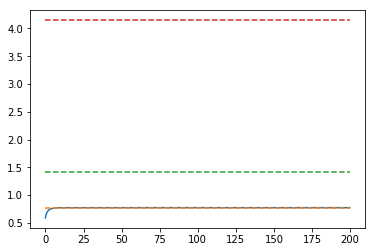

In [98]:
plt.plot(vrange,rnp[uval])
plt.plot([min(vrange),max(vrange)],[rminus,rminus],'--')
plt.plot([min(vrange),max(vrange)],[rplus,rplus],'--')
plt.plot([min(vrange),max(vrange)],[rcosm,rcosm],'--')
#plt.ylim(rcosm-.0000001,rcosm+.0000001)
plt.show()

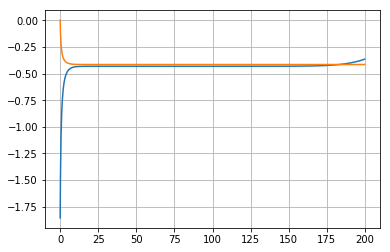

In [99]:
plt.plot(vrange,dsignpv[uval])
plt.plot(vrange,dsignpu[uval])
#plt.yscale('log')
#plt.ylim(-.11,-.09)
plt.grid()
plt.show()

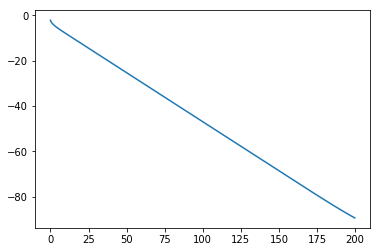

In [100]:
plt.plot(vrange,signp[uval])
plt.show()

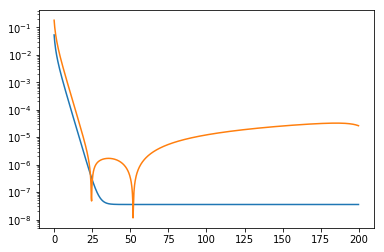

In [107]:
plt.plot(vrange,np.abs(drnpu[uval]))
plt.plot(vrange,np.abs(drnpv[uval]))
plt.yscale('log')
plt.show()

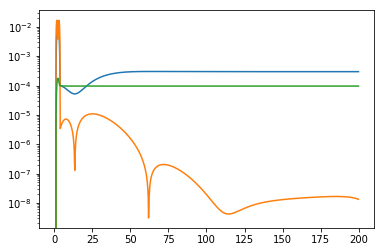

In [102]:
plt.plot(vrange,np.abs(phinp[uval]))
plt.plot(vrange,np.abs(dphinpv[uval]))
plt.plot(vrange,np.abs(dphinpu[uval]))
#plt.plot(vrange,dphinpv[0])
plt.yscale('log')
plt.show()

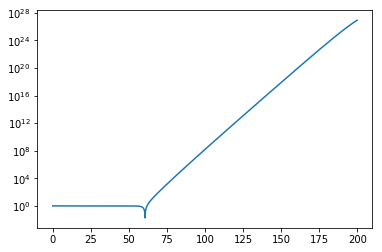

In [106]:
plt.plot(vrange,np.abs(massnp[uval]))
#plt.ylim(massnp[uval,-1]-.00000000001,massnp[uval,-1]+.00000000001)
plt.yscale('log')
plt.show()

In [26]:
print(Nu,Nu,Nu)

741 741 741


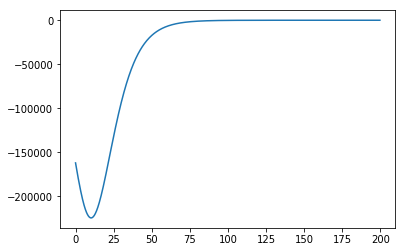

[-1.03286184e+06 -1.04591336e+06 -1.05889387e+06 -1.07179415e+06
 -1.08460488e+06 -1.09731670e+06 -1.10991814e+06 -1.12236590e+06
 -1.13458622e+06 -1.14656609e+06 -1.15837939e+06 -1.17011766e+06
 -1.18180480e+06 -1.19337047e+06 -1.20469954e+06 -1.21571710e+06
 -1.22644340e+06 -1.23697240e+06 -1.24738559e+06 -1.25767569e+06
 -1.26776886e+06 -1.27762116e+06 -1.28722247e+06 -1.29656509e+06
 -1.30564158e+06 -1.31444472e+06 -1.32296759e+06 -1.33120351e+06
 -1.33914611e+06 -1.34678932e+06 -1.35412738e+06 -1.36115483e+06
 -1.36786655e+06 -1.37425776e+06 -1.38032400e+06 -1.38606117e+06
 -1.39146552e+06 -1.39653365e+06 -1.40126251e+06 -1.40564944e+06
 -1.40969211e+06 -1.41338856e+06 -1.41673721e+06 -1.41973683e+06
 -1.42238655e+06 -1.42468585e+06 -1.42663458e+06 -1.42823294e+06
 -1.42948146e+06 -1.43038103e+06 -1.43093287e+06 -1.43113853e+06
 -1.43099987e+06 -1.43051908e+06 -1.42969866e+06 -1.42854140e+06
 -1.42705037e+06 -1.42522894e+06 -1.42308074e+06 -1.42060967e+06
 -1.41781986e+06 -1.41471

In [29]:
rnp2=rnp[0,-100]+10**(-15)*np.random.random(Nv)

dsignpv3=2*((massnp[0,-100]*rnp2-Q**2-1/3*Lambda*rnp2**4)/(rnp2**3-2*massnp[0,-100]*rnp2**2+Q**2*rnp2-Lambda/3*rnp2**5))*drnpv[0]
plt.plot(vrange,dsignpv3)
#plt.ylim(-1,1)
plt.show()
print(dsignpv2)

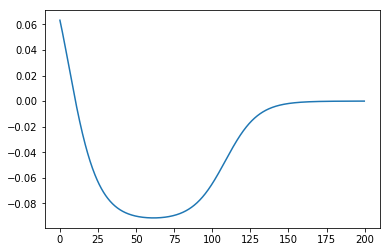

[ 6.32432681e-02  6.21361265e-02  6.10170356e-02  5.98863274e-02
  5.87443459e-02  5.75914469e-02  5.64278941e-02  5.52524302e-02
  5.40626558e-02  5.28594258e-02  5.16474045e-02  5.04313540e-02
  4.92125352e-02  4.79882815e-02  4.67546857e-02  4.55100675e-02
  4.42565427e-02  4.29985125e-02  4.17392730e-02  4.04787475e-02
  3.92148642e-02  3.79468467e-02  3.66750740e-02  3.53999953e-02
  3.41220584e-02  3.28417091e-02  3.15593904e-02  3.02755419e-02
  2.89905993e-02  2.77049939e-02  2.64191517e-02  2.51334936e-02
  2.38484341e-02  2.25643815e-02  2.12817372e-02  2.00008952e-02
  1.87222419e-02  1.74461559e-02  1.61730073e-02  1.49031578e-02
  1.36369603e-02  1.23747585e-02  1.11168871e-02  9.86367133e-03
  8.61542679e-03  7.37245954e-03  6.13506589e-03  4.90353231e-03
  3.67813543e-03  2.45914196e-03  1.24680875e-03  4.13827574e-05
 -1.15689892e-03 -2.34780898e-03 -3.53112986e-03 -4.70665366e-03
 -5.87418205e-03 -7.03352615e-03 -8.18450643e-03 -9.32695260e-03
 -1.04607034e-02 -1.15856

In [27]:
dsignpv2=2*((massnp[0,0]*rnp[0]-Q**2-1/3*Lambda*rnp[0]**4)/(rnp[0]**3-2*massnp[0,0]*rnp[0]**2+Q**2*rnp[0]-Lambda/3*rnp[0]**5))*drnpv[0]
plt.plot(vrange,dsignpv2)
plt.show()
print(dsignpv2)

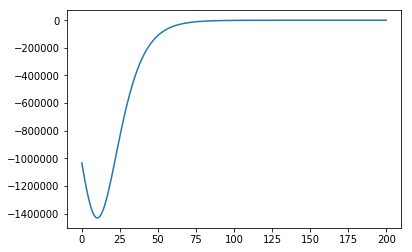

[-1.03286184e+06 -1.04591336e+06 -1.05889387e+06 -1.07179415e+06
 -1.08460488e+06 -1.09731670e+06 -1.10991814e+06 -1.12236590e+06
 -1.13458622e+06 -1.14656609e+06 -1.15837939e+06 -1.17011766e+06
 -1.18180480e+06 -1.19337047e+06 -1.20469954e+06 -1.21571710e+06
 -1.22644340e+06 -1.23697240e+06 -1.24738559e+06 -1.25767569e+06
 -1.26776886e+06 -1.27762116e+06 -1.28722247e+06 -1.29656509e+06
 -1.30564158e+06 -1.31444472e+06 -1.32296759e+06 -1.33120351e+06
 -1.33914611e+06 -1.34678932e+06 -1.35412738e+06 -1.36115483e+06
 -1.36786655e+06 -1.37425776e+06 -1.38032400e+06 -1.38606117e+06
 -1.39146552e+06 -1.39653365e+06 -1.40126251e+06 -1.40564944e+06
 -1.40969211e+06 -1.41338856e+06 -1.41673721e+06 -1.41973683e+06
 -1.42238655e+06 -1.42468585e+06 -1.42663458e+06 -1.42823294e+06
 -1.42948146e+06 -1.43038103e+06 -1.43093287e+06 -1.43113853e+06
 -1.43099987e+06 -1.43051908e+06 -1.42969866e+06 -1.42854140e+06
 -1.42705037e+06 -1.42522894e+06 -1.42308074e+06 -1.42060967e+06
 -1.41781986e+06 -1.41471

In [28]:
massnp2=massnp[0,-1]+10**(-19)*np.random.random(Nv)

dsignpv2=2*((massnp2*rnp[0,-1]-Q**2-1/3*Lambda*rnp[0,-1]**4)/(rnp[0,-1]**3-2*massnp2*rnp[0,-1]**2+Q**2*rnp[0,-1]-Lambda/3*rnp[0,-1]**5))*drnpv[0]
plt.plot(vrange,dsignpv2)
#plt.ylim(-.12,-.09)
plt.show()
print(dsignpv2)

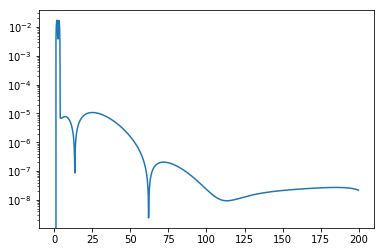

In [31]:
print(1.0,.5*(1-2*massnp[0,0]/rnp[0,0]+Q**2.0/rnp[0,0]**2.0-Lambda*rnp[0,0]**2.0/3))

1.0 0.053383333333333324
